In [1]:
import numpy as np
import tensorflow as tf
import keras
from keras.utils import np_utils
from keras.layers import Input, Dense
from keras.models import Model
from keras import losses
import matplotlib.pyplot as plt
import pandas as pd
from pandas import DataFrame

#Define load embed
def load_embed():
    doc_embed   = tf.constant(np.load(f"doc_collect_embed/doc_embed_col.npy"))
    word_embed  = tf.constant(np.load(f"doc_collect_embed/word_embed_col.npy"))
    topic_embed = tf.constant(np.load(f"doc_collect_embed/topic_embed_col.npy"))
    return (doc_embed, word_embed, topic_embed)

#Define Topic Dist
def topic_dist():
    embeds = load_embed()
    doc_embed = embeds[0]
    topic_embed = embeds[2]
    norm_doc = tf.nn.softmax(doc_embed)
    topic_dist = tf.linalg.matmul(norm_doc, topic_embed)
    return topic_dist

In [2]:
#Load Data
data = topic_dist()
print(data.shape)

(300, 300)


In [3]:
#Sheet with the prev 10 years concatenated to predict the next year. Each sample is 3000 features for 300 topic dists over 10 years.
inputs = pd.read_excel(f"doc_collect_embed/Data_col.xlsx")
data_features = inputs.loc[:, inputs.columns]
data_features = data_features.drop(['Sample'],axis=1)
data_features=tf.convert_to_tensor(data_features)

In [4]:
print(data_features.shape)
print(type(data_features))

x_train = data_features[9:-61, :]
x_test = data_features[240:-1, :]
print(x_train.shape)
print(x_test.shape)

y_train = data[10:-60, :]
y_test = data[241:, :]
print(y_train.shape)
print(y_test.shape)

(300, 3000)
<class 'tensorflow.python.framework.ops.EagerTensor'>
(230, 3000)
(59, 3000)
(230, 300)
(59, 300)


Epoch 1/10
10/10 [==============================] - 1s 32ms/step - loss: -0.5047 - msle: 0.1335 - val_loss: -0.6126 - val_msle: 0.1839
Epoch 2/10
10/10 [==============================] - 0s 20ms/step - loss: -0.6180 - msle: 0.1797 - val_loss: -0.6233 - val_msle: 0.1693
Epoch 3/10
10/10 [==============================] - 0s 21ms/step - loss: -0.6255 - msle: 0.1601 - val_loss: -0.6308 - val_msle: 0.1542
Epoch 4/10
10/10 [==============================] - 0s 21ms/step - loss: -0.6296 - msle: 0.1491 - val_loss: -0.6351 - val_msle: 0.1402
Epoch 5/10
10/10 [==============================] - 0s 20ms/step - loss: -0.6334 - msle: 0.1374 - val_loss: -0.6405 - val_msle: 0.1336
Epoch 6/10
10/10 [==============================] - 0s 20ms/step - loss: -0.6370 - msle: 0.1306 - val_loss: -0.6378 - val_msle: 0.1259
Epoch 7/10
10/10 [==============================] - 0s 20ms/step - loss: -0.6427 - msle: 0.1226 - val_loss: -0.6340 - val_msle: 0.1197
Epoch 8/10
10/10 [==============================] - 0s 

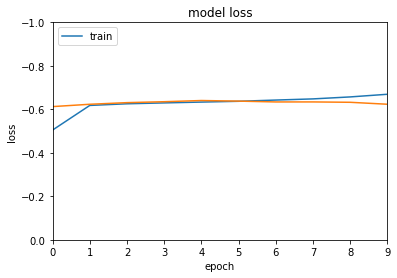

In [5]:
input_size = 3000
hidden_size1 = 1500
hidden_size2 = 750
hidden_size3 = 325
output_size = 300
num_epochs = 10

input_data = Input(shape=(input_size,))
hidden_d_1 = Dense(hidden_size1, activation='tanh')(input_data)
hidden_d_2 = Dense(hidden_size2, activation='tanh')(hidden_d_1)
hidden_d_3 = Dense(hidden_size3, activation='tanh')(hidden_d_2)
predicted = Dense(output_size, activation='tanh')(hidden_d_3)

predictor = Model(input_data, predicted)
predictor.compile(optimizer='Adam', loss='cosine_similarity', metrics=['msle'] ) #Can also do MSE or MAE here for loss.

p = predictor.fit(x_train, y_train,
epochs=num_epochs,
steps_per_epoch=10,
shuffle=False,
validation_split=0.1)
#validation_data=(X_test, Y_test))

#Plotting loss
plt.plot(p.history['loss'])
plt.plot(p.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
#plt.legend(['train', 'validation'], loc='upper left')
plt.axis([0, num_epochs-1, 0, -1])
plt.show()


In [6]:
trainScore = predictor.evaluate(x_train,y_train)
testScore = predictor.evaluate(x_test,y_test)

2/2 [==============================] - 0s 8ms/step - loss: -0.6136 - msle: 0.1117
